## Environment V2



Example of how to use the InventoryEnv class to simulate an inventory management scenario, being in this case randomly.

In [4]:
from env2 import InventoryEnv
import numpy as np 
import random

In [5]:

envi = InventoryEnv(num_customers=3, grid_size=10, capacity_supplier=30, capacity_customers=20, ss_customers=0, ss_supplier=0, num_trucks=2, scale_supplier=10.0, scale_customers=8.0, benchmark_location=1)
obs = envi.reset()
print("Initial State", obs)
INFO=[]
RW = []

for step in range(5):
    action = random.choice(envi.action_state_space())
    obs, reward, done, info = envi.step(action)
    print(f"\ Step {step + 1}")
    print("ACTION:", action)
    print('POST-ACTION STATE:',info['post_action_state'] )
    print("DEMAND:", info["demand"])
    print("BACKORDERS QUANTITY:", info["backorders"])
    print("SERVICE LEVEL:", info["service_level"])
    print("REWARD:", reward)
    print('PRODUCTION:',info['production'])
    print("NEW STATE:", obs)
    INFO.append(info)
    RW.append(reward)
    
    
envi.close()

Initial State [12  5  5  5]
\ Step 1
ACTION: [7 2 1 0]
POST-ACTION STATE: [2, 7, 6, 5]
DEMAND: [6, 32, 12]
BACKORDERS QUANTITY: [0, 26, 7]
SERVICE LEVEL: 0
REWARD: -343.15537446092713
PRODUCTION: 5
NEW STATE: [7 1 0 0]
\ Step 2
ACTION: [1 0 3 3]
POST-ACTION STATE: [0, 1, 3, 3]
DEMAND: [2, 13, 1]
BACKORDERS QUANTITY: [1, 10, 0]
SERVICE LEVEL: 0
REWARD: -128.26882723033592
PRODUCTION: 7
NEW STATE: [7 0 0 2]
\ Step 3
ACTION: [0 2 5 0]
POST-ACTION STATE: [0, 2, 5, 2]
DEMAND: [3, 8, 2]
BACKORDERS QUANTITY: [1, 3, 0]
SERVICE LEVEL: 0
REWARD: -58.155374460927135
PRODUCTION: 2
NEW STATE: [2 0 0 0]
\ Step 4
ACTION: [1 0 0 0]
POST-ACTION STATE: [1, 0, 0, 0]
DEMAND: [8, 0, 1]
BACKORDERS QUANTITY: [8, 0, 1]
SERVICE LEVEL: 0
REWARD: -89.5
PRODUCTION: 9
NEW STATE: [10  0  0  0]
\ Step 5
ACTION: [2 0 6 2]
POST-ACTION STATE: [0, 0, 6, 2]
DEMAND: [6, 9, 4]
BACKORDERS QUANTITY: [6, 3, 2]
SERVICE LEVEL: 0
REWARD: -125.26882723033592
PRODUCTION: 21
NEW STATE: [21  0  0  0]


## voy a  jalar este curso 


### Random Policy

Lets first evaluate the how the cost behaving when you select a random action that is posible in the environment.This will give us an idea of how is our policy behaving in the environment compared to pure randomness.We simulate 50 episodes with 50 days in each one.

In [8]:
def analyze_random_policy(env, num_episodes=50):
    """Analyze the performance of a random policy in the inventory environment."""
    random_rewards = []
    random_costs = []
    random_service_levels = []
    
    for episode in range(num_episodes):
        state = env.reset()
        episode_reward = 0
        episode_cost = 0
        episode_service = []
        
        for step in range(50):
            # Política aleatoria
            valid_actions = env.posible_actions_stock(state, env.capacity_customers[0])
            if valid_actions:
                action = random.choice(valid_actions)
            else:
                action = [0] * env.action_space.shape[0]
            
            next_state, reward, done, info = env.step(action)
            episode_reward += reward
            episode_cost += info['costs']
            episode_service.append(info['service_level'])
            state = next_state
        
        random_rewards.append(episode_reward)
        random_costs.append(episode_cost)
        random_service_levels.append(np.mean(episode_service))
    
    print("===Random Policy===")
    print(f"Mean  REWARD: {np.mean(random_rewards):.2f} ± {np.std(random_rewards):.2f}")
    print(f"range REWARD: [{np.min(random_rewards):.2f}, {np.max(random_rewards):.2f}]")
    print(f"Mean Cost : {np.mean(random_costs):.2f} ± {np.std(random_costs):.2f}")
    print(f"Mean Service Level: {np.mean(random_service_levels):.2f}")
    
    return random_rewards, random_costs, random_service_levels

In [ ]:
# Example usage of the InventoryEnv and random policy analysis
env = InventoryEnv(num_customers=3, grid_size=10, capacity_supplier=30, capacity_customers=20, ss_customers=0, ss_supplier=0, num_trucks=2, scale_supplier=10.0, scale_customers=8.0, benchmark_location=1)
env.reset()
random_rewards, random_costs, random_service_levels = analyze_random_policy(env, num_episodes=50)


We understand that this gives us a wide range of rewards, meaning that the NN could not give us good results , that why we apply a normalization to train de DQN
We fix a baseline in order to normalize the reward.

In [ ]:
# Get baseline cost for the environment per day
env = InventoryEnv(num_customers=3, grid_size=10, capacity_supplier=30, capacity_customers=20, ss_customers=0, ss_supplier=0, num_trucks=2, scale_supplier=10.0, scale_customers=8.0, benchmark_location=1)
costs = []
for _ in range(50):
    s = env.reset()
    total = 0
    for _ in range(50):
        a = random.choice(env.action_state_space())
        _, reward, _, _  = env.step(a)
        total += reward
    costs.append(total)
baseline_reward = np.mean(costs)/50  # Mean cost per day
print(f"Baseline Reward per Day: {baseline_reward:.2f}")
env.close()


Baseline Reward per Day: -181.72


In [ ]:
baseline_reward = 180


envi = InventoryEnv(
    num_customers=3,
    grid_size=10,
    capacity_supplier=30,
    capacity_customers=20,
    ss_customers=0,
    ss_supplier=0,
    num_trucks=2,
    scale_supplier=10.0,
    scale_customers=8.0,
    benchmark_location=1,
    custom_reward=180  
)



envi.close()

##  Siimpplee DQN

In [3]:
# Reinforcement Learning with DQN for Inventory  and transportation 
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from env2 import InventoryEnv

# Set device for GPU usage
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class ActionMapper:
    def __init__(self, action_space):
        self.sizes = action_space.nvec
        self.action_dim = np.prod(self.sizes)
        self.lookup = [np.unravel_index(i, self.sizes) for i in range(self.action_dim)]

    def get_action(self, index):
        return self.lookup[index]

    def get_index(self, action):
        return np.ravel_multi_index(tuple(action), self.sizes)

    def sample(self):
        return tuple(np.random.randint(0, s) for s in self.sizes)

    def __len__(self):
        return self.action_dim


# Settings
num_episodes = 1500
steps_per_episode = 50
gamma = 0.95
epsilon = 0.4
epsilon_decay = 0.995
epsilon_min = 0.10
learning_rate = 0.0001

# Call environment
env = InventoryEnv(num_customers=3, grid_size=10, capacity_supplier=30, capacity_customers=20, ss_customers=0, ss_supplier=0, num_trucks=2, scale_supplier=10.0, scale_customers=8.0, benchmark_location=1, custom_reward=baseline_reward)
state_dim = env.observation_space.shape[0]
action_mapper = ActionMapper(env.action_space)
print("action_mapper.sizes:", action_mapper.sizes)

action_dim = len(action_mapper)


class SimpleQNet(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(256, 128)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(128, 64)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(64, 32)
        self.relu4 = nn.ReLU()
        self.out = nn.Linear(32, output_dim)

    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.relu3(self.fc3(x))
        x = self.relu4(self.fc4(x))
        return self.out(x)

model = SimpleQNet(state_dim, action_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.MSELoss()

for episode in range(num_episodes):
    state = env.reset()
    total_reward = 0
    total_cost = 0

    for step in range(steps_per_episode):
        state_tensor = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

        # Generar acciones válidas según el estado actual
        valid_actions = env.posible_actions_stock(state, env.capacity_customers[0])

        if not valid_actions:
            # No se puede hacer nada, acción nula
            action = [0] * env.action_space.shape[0]
        else:
            valid_indices = [action_mapper.get_index(a) for a in valid_actions]

            # ε-greedy: exploración o explotación
            if random.random() < epsilon:
                action = random.choice(valid_actions)
            else:
                with torch.no_grad():
                    q_values = model(state_tensor)
                    best_index = max(valid_indices, key=lambda i: q_values[0, i].item())
                    action = action_mapper.get_action(best_index)

        action_index = action_mapper.get_index(action)

        # Ejecutar acción
        next_state, reward, done, info = env.step(action)
        next_state_tensor = torch.tensor(next_state, dtype=torch.float32, device=device).unsqueeze(0)

        # Calcular el valor objetivo Q (Bellman)
        with torch.no_grad():
            next_valid_actions = env.posible_actions_stock(next_state, env.capacity_customers[0])
            if next_valid_actions:
                next_valid_indices = [action_mapper.get_index(a) for a in next_valid_actions]
                next_q_values = model(next_state_tensor)
                max_next_q = max([next_q_values[0, i].item() for i in next_valid_indices])
            else:
                max_next_q = 0.0

            target = reward + gamma * max_next_q

        # Retropropagación y actualización
        pred_q = model(state_tensor)[0, action_index]
        loss = loss_fn(pred_q, torch.tensor(target, dtype=torch.float32, device=device))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Siguiente estado
        state = next_state
        total_reward += reward
        total_cost += info['costs']

    # Decaer epsilon
    if epsilon > epsilon_min:
        epsilon *= epsilon_decay

    print(f"Episode {episode + 1}: total reward = {total_reward:.2f}, total cost = {total_cost:.2f}, epsilon = {epsilon:.4f}")

# Guardar modelo
torch.save(model.state_dict(), "dqn_resitv1.pt")

# Cerrar entorno
env.close()


NameError: name 'baseline_reward' is not defined

Based on the structure of the DQN policy we can arrange a Reinforce Policy without baseline:

### REINFORCE without baseline 

In [8]:
class PolicyNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim),
            nn.Softmax(dim=-1)  # salida como distribución de probabilidad
        )

    def forward(self, x):
        return self.fc(x)


def select_action(policy, state, valid_indices):
    state_tensor = torch.tensor(state, dtype=torch.float32, device=device)
    probs = policy(state_tensor)

    # Masked sampling (acciones inválidas a 0)
    mask = torch.zeros_like(probs)
    mask[valid_indices] = 1
    masked_probs = probs * mask
    masked_probs = masked_probs / masked_probs.sum()

    dist = torch.distributions.Categorical(masked_probs)
    action_index = dist.sample()
    return action_index.item(), dist.log_prob(action_index)


policy = PolicyNetwork(state_dim, action_dim).to(device)
optimizer = optim.Adam(policy.parameters(), lr=0.0001)

total_cost = []

for episode in range(300):
    state = env.reset()
    log_probs = []
    rewards = []
    total_cost_per_episode = 0
    

    for step in range(steps_per_episode):
        valid_actions = env.action_state_space()
        valid_indices = [action_mapper.get_index(a) for a in valid_actions]

        action_index, log_prob = select_action(policy, state, valid_indices)
        action = action_mapper.get_action(action_index)

        next_state, reward, done, info = env.step(action)

        log_probs.append(log_prob)
        rewards.append(reward)
        total_cost_per_episode += info.get('costs', 0)

        state = next_state
        if done:
            break

    # Calcular retornos (G_t)
    total_cost.append(total_cost_per_episode)
    returns = []
    print(f"Episode {episode + 1}: total cost = {total_cost_per_episode:.2f}")
    G = 0
    for r in reversed(rewards):
        G = r + gamma * G
        returns.insert(0, G)
    returns = torch.tensor(returns, dtype=torch.float32, device=device)
    returns = (returns - returns.mean()) / (returns.std() + 1e-9)

    # Calcular pérdida
    loss = -torch.sum(torch.stack(log_probs) * returns)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print(f"[{episode}] Recompensa total: {sum(rewards)}")


torch.save(policy.state_dict(), "policy_reinforce2.pt")

Episode 1: total cost = 8425.29
[0] Recompensa total: 3.9872529487581265
Episode 2: total cost = 10693.46
[1] Recompensa total: -8.613645041692878
Episode 2: total cost = 10693.46
[1] Recompensa total: -8.613645041692878
Episode 3: total cost = 9061.27
[2] Recompensa total: 0.3984743647768765
Episode 3: total cost = 9061.27
[2] Recompensa total: 0.3984743647768765
Episode 4: total cost = 10094.02
[3] Recompensa total: -5.427914325392151
Episode 4: total cost = 10094.02
[3] Recompensa total: -5.427914325392151
Episode 5: total cost = 10604.66
[4] Recompensa total: -8.298113178889842
Episode 5: total cost = 10604.66
[4] Recompensa total: -8.298113178889842
Episode 6: total cost = 8614.75
[5] Recompensa total: 2.784708069266561
Episode 6: total cost = 8614.75
[5] Recompensa total: 2.784708069266561
Episode 7: total cost = 8934.68
[6] Recompensa total: 1.3018029418594055
Episode 7: total cost = 8934.68
[6] Recompensa total: 1.3018029418594055
Episode 8: total cost = 8206.68
[7] Recompensa 

In [9]:
def evaluate_policy(env, policy, action_mapper, episodes=10):
    total_rewards = []
    service_levels = []
    total_cost = []

    policy = policy.to(device)

    for ep in range(episodes):
        state = env.reset()
        episode_reward = 0
        episode_service_levels = []
        episode_cost = 0

        done = False
        for _ in range(50):  # o el número de steps por episodio
            state_tensor = torch.tensor(state, dtype=torch.float32, device=device)

            with torch.no_grad():
                probs = policy(state_tensor)
                action_index = torch.argmax(probs).item()
                action = action_mapper.get_action(action_index)

            next_state, reward, done, info = env.step(action)
            episode_reward += reward
            episode_cost += info.get('costs', 0)
            service_levels.append(info.get("service_level", 0))
            state = next_state

        total_rewards.append(episode_reward)
        total_cost.append(episode_cost)

    avg_reward = np.mean(total_rewards)
    avg_service = np.mean(service_levels)
    avg_cost = np.mean(total_cost)

    std_reward = np.std(total_rewards)
    std_service = np.std(service_levels)
    std_cost = np.std(total_cost)
    print(f"Recompensa promedio: {avg_reward:.2f} ± {std_reward:.2f}")
    print(f"Nivel de servicio promedio: {avg_service:.2f} ± {std_service:.2f}")
    print(f"Costo promedio: {avg_cost:.2f} ± {std_cost:.2f}")

In [10]:
env.reset()
evaluate_policy(env, policy, action_mapper, episodes=50)

Recompensa promedio: 34.07 ± 3.53
Nivel de servicio promedio: 0.57 ± 0.49
Costo promedio: 3895.44 ± 622.65


/tmp/ipykernel_14307/1858005521.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  policy.load_state_dict(torch.load("policy_reinforce.pt", map_location=device))
/tmp/ipyke

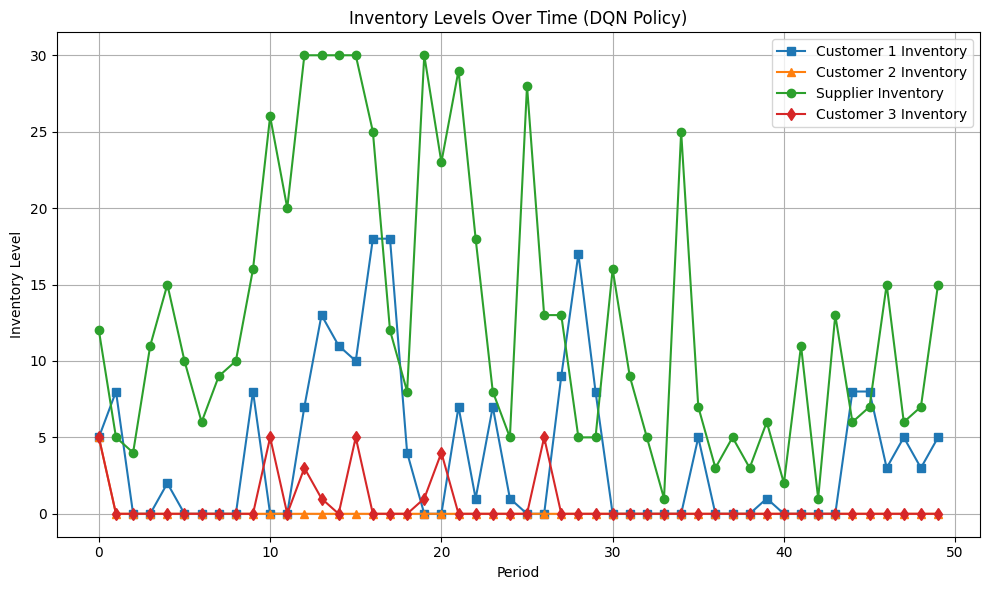

In [12]:
policy = PolicyNetwork(state_dim, action_dim).to(device)
policy.load_state_dict(torch.load("policy_reinforce.pt", map_location=device))
policy.eval()


with torch.no_grad():
    probs = policy(state_tensor.squeeze(0).to(device))  
    valid_mask = torch.zeros_like(probs)
    valid_mask[valid_indices] = 1
    masked_probs = probs * valid_mask
    masked_probs /= masked_probs.sum()

    action_index = torch.argmax(masked_probs).item()  # acción más probable
    action = action_mapper.get_action(action_index)


import torch
import pandas as pd
import matplotlib.pyplot as plt

policy = PolicyNetwork(state_dim, action_dim).to(device)
policy.load_state_dict(torch.load("policy_reinforce.pt", map_location=device))
policy.eval()

def simulate_inventory_env_reinforce(env, policy, action_mapper, n_days=50):
    state = env.reset()
    history = []

    for day in range(n_days):
        state_tensor = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

        valid_actions = env.action_state_space()
        if not valid_actions:
            action = [0] * env.action_space.shape[0]
        else:
            valid_indices = [action_mapper.get_index(a) for a in valid_actions]
            with torch.no_grad():
                probs = policy(state_tensor.squeeze(0))
                mask = torch.zeros_like(probs)
                mask[valid_indices] = 1
                masked_probs = probs * mask
                masked_probs = masked_probs / masked_probs.sum()

                action_index = torch.argmax(masked_probs).item()
                action = action_mapper.get_action(action_index)

        next_state, reward, done, info = env.step(action)

        history.append({
            'day': day,
            'state': state.tolist(),
            'action': list(action),
            'reward': reward,
            'total_cost': info.get('costs', 0),
            'market_sale': info.get('market_sold', 0),
            'market_revenue': info.get('market_revenue', 0),
            'demand': info.get('demand', 0),
            'production': info.get('production', 0),
            'service_rate': info.get('service_level', 1.0),  
            'period': day,
            'service_level_per_store': info.get('service_level_per_store',[0] * env.num_customers)
        })

        state = next_state

    return pd.DataFrame(history)


df_sim = simulate_inventory_env_reinforce(env, policy, action_mapper, n_days=50)


def plot_inventory(df):
    supplier_inv = df['state'].apply(lambda x: x[0])
    customer1_inv = df['state'].apply(lambda x: x[1])
    customer2_inv = df['state'].apply(lambda x: x[2])
    customer3_inv = df['state'].apply(lambda x: x[3])

    periods = df['period']

    plt.figure(figsize=(10, 6))
    plt.plot(periods, customer1_inv, label='Customer 1 Inventory', marker='s')
    plt.plot(periods, customer2_inv, label='Customer 2 Inventory', marker='^')
    plt.plot(periods, supplier_inv, label='Supplier Inventory', marker='o')
    plt.plot(periods, customer3_inv, label='Customer 3 Inventory', marker='d')

    plt.xlabel('Period')
    plt.ylabel('Inventory Level')
    plt.title('Inventory Levels Over Time (DQN Policy)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# KPIs
# ... igual que antes ...

plot_inventory(df_sim)

### DQN with Replay Buffer

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
import collections #built-in 
from env2 import InventoryEnv
from tqdm import tqdm

# Set device for GPU usage
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ---------------- AGENTE DQN ------------------
class DQNAgent:
    def __init__(self, state_dim, action_dim, action_mapper, lr=0.001, buffer_size=10000):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.action_mapper = action_mapper
        self.memory = collections.deque(maxlen=buffer_size)
        self.batch_size = 32

        self.q_network = SimpleQNet(state_dim, action_dim).to(device)
        self.target_network = SimpleQNet(state_dim, action_dim).to(device)
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=lr)

        self.update_target_network()

    def update_target_network(self):
        self.target_network.load_state_dict(self.q_network.state_dict())

    def remember(self, state, action, reward, next_state, done, valid_actions, next_valid_actions):
        self.memory.append((state, action, reward, next_state, done, valid_actions, next_valid_actions))

    def replay(self, gamma=0.95):
        if len(self.memory) < self.batch_size:
            return

        batch = random.sample(self.memory, self.batch_size)
        # Avoid warning by converting list of arrays to a single numpy array first
        states = torch.FloatTensor(np.array([e[0] for e in batch])).to(device)
        actions = torch.LongTensor([e[1] for e in batch]).to(device)
        rewards = torch.FloatTensor([e[2] for e in batch]).to(device)
        next_states = torch.FloatTensor([e[3] for e in batch]).to(device)
        dones = torch.BoolTensor([e[4] for e in batch]).to(device)

        current_q_values = self.q_network(states).gather(1, actions.unsqueeze(1)).squeeze()

        next_q_values = torch.zeros(self.batch_size, device=device)
        for i, (next_state, done, next_valid_actions) in enumerate(zip(next_states, dones, [e[6] for e in batch])):
            if not done and next_valid_actions:
                next_valid_indices = [self.action_mapper.get_index(a) for a in next_valid_actions]
                with torch.no_grad():
                    next_q = self.target_network(next_state.unsqueeze(0))
                    next_q_values[i] = max([next_q[0, idx].item() for idx in next_valid_indices])

        target_q_values = rewards + gamma * next_q_values * (~dones)
        loss = nn.MSELoss()(current_q_values, target_q_values)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()


def train_improved_dqn():
    env = InventoryEnv(num_customers=3, grid_size=10, capacity_supplier=30, capacity_customers=20, ss_customers=0, ss_supplier=0, num_trucks=2, scale_supplier=10.0, scale_customers=8.0, benchmark_location=1, custom_reward=baseline_reward)
    action_mapper = ActionMapper(env.action_space)
    agent = DQNAgent(env.observation_space.shape[0], len(action_mapper), action_mapper)

    num_episodes = 2000
    steps_per_episode = 50
    epsilon = 1.0
    epsilon_decay = 0.995
    epsilon_min = 0.01
    target_update_freq = 10

    rewards_history = []

    for episode in tqdm(range(num_episodes)):
        state = env.reset()
        total_reward = 0

        for step in range(steps_per_episode):
            valid_actions = env.posible_actions_stock(state, env.capacity_customers[0])

            if not valid_actions:
                action = [0] * env.action_space.shape[0]
            elif random.random() < epsilon:
                action = random.choice(valid_actions)
            else:
                valid_indices = [action_mapper.get_index(a) for a in valid_actions]
                state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
                with torch.no_grad():
                    q_values = agent.q_network(state_tensor)
                    best_index = max(valid_indices, key=lambda i: q_values[0, i].item())
                    action = action_mapper.get_action(best_index)

            action_index = action_mapper.get_index(action)
            next_state, reward, done, info = env.step(action)

            improved_reward = reward
            next_valid_actions = env.posible_actions_stock(next_state, env.capacity_customers[0])

            agent.remember(state, action_index, improved_reward, next_state, done,
                           valid_actions, next_valid_actions)

            if len(agent.memory) >= agent.batch_size:
                agent.replay()

            state = next_state
            total_reward += improved_reward

        rewards_history.append(total_reward)

        if episode % target_update_freq == 0:
            agent.update_target_network()

        epsilon = max(epsilon_min, epsilon * epsilon_decay)

        if episode % 10 == 0:
            avg = np.mean(rewards_history[-10:])
            print(f"Episode {episode}: Avg Reward = {avg:.2f}, Epsilon = {epsilon:.4f}")

    return agent, rewards_history



In [16]:
# Execute the training
if __name__ == "__main__":
    agent, rewards = train_improved_dqn()
torch.save(agent.q_network.state_dict(), "policy_dqn_replay2.pt")

  0%|          | 1/2000 [00:10<5:51:18, 10.54s/it]

Episode 0: Avg Reward = -4.85, Epsilon = 0.9950


  1%|          | 11/2000 [13:59<48:53:14, 88.48s/it]

Episode 10: Avg Reward = 2.07, Epsilon = 0.9464


  1%|          | 21/2000 [30:36<55:34:33, 101.10s/it]

Episode 20: Avg Reward = 2.32, Epsilon = 0.9001


  2%|▏         | 31/2000 [48:11<57:49:54, 105.74s/it]

Episode 30: Avg Reward = 1.52, Epsilon = 0.8561


  2%|▏         | 41/2000 [1:05:27<57:57:14, 106.50s/it]

Episode 40: Avg Reward = -2.75, Epsilon = 0.8142


  3%|▎         | 51/2000 [1:23:23<59:09:18, 109.27s/it]

Episode 50: Avg Reward = 1.02, Epsilon = 0.7744


  3%|▎         | 61/2000 [1:42:28<59:46:11, 110.97s/it]

Episode 60: Avg Reward = -4.33, Epsilon = 0.7366


  4%|▎         | 71/2000 [2:00:43<58:30:32, 109.19s/it]

Episode 70: Avg Reward = -1.99, Epsilon = 0.7005


  4%|▍         | 81/2000 [2:19:23<59:54:45, 112.39s/it]

Episode 80: Avg Reward = 1.09, Epsilon = 0.6663


  5%|▍         | 91/2000 [2:38:33<61:38:33, 116.25s/it]

Episode 90: Avg Reward = 0.55, Epsilon = 0.6337


  5%|▌         | 101/2000 [2:57:28<60:37:55, 114.94s/it]

Episode 100: Avg Reward = 2.18, Epsilon = 0.6027


  6%|▌         | 111/2000 [3:17:19<62:57:09, 119.97s/it]

Episode 110: Avg Reward = -0.68, Epsilon = 0.5733


  6%|▌         | 121/2000 [3:36:57<62:22:15, 119.50s/it]

Episode 120: Avg Reward = 1.79, Epsilon = 0.5452


  7%|▋         | 131/2000 [3:59:44<74:04:57, 142.70s/it]

Episode 130: Avg Reward = -0.15, Epsilon = 0.5186


: 

In [ ]:
def evaluate_policy(agent, env, num_episodes=1, show_policy=True):
    total_rewards = []
    service_levels = []
    cost_history = []

    agent.q_network = agent.q_network.to(device)

    for episode in range(num_episodes):
        state = env.reset()
        episode_reward = 0
        episode_service_levels = []
        cost = 0

        if show_policy:
            print(f"\n📘 POLÍTICA APRENDIDA - EPISODIO {episode + 1}")

        for step in range(50):
            valid_actions = env.posible_actions_stock(state, env.capacity_customers[0])

            if not valid_actions:
                action = [0] * env.action_space.shape[0]
            else:
                valid_indices = [action_mapper.get_index(a) for a in valid_actions]
                state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
                with torch.no_grad():
                    q_values = agent.q_network(state_tensor)
                    best_index = max(valid_indices, key=lambda i: q_values[0, i].item())
                    action = action_mapper.get_action(best_index)

            if show_policy and step % 5 ==0:
                print(f"🔹 Estado: {state} → Acción elegida: {action}")

            next_state, reward, done, info = env.step(action)
            episode_reward += reward
            episode_service_levels.append(info['service_level'])
            cost += info['costs'] + info['market_revenue']
            state = next_state

        total_rewards.append(episode_reward)
        service_levels.append(np.mean(episode_service_levels))
        cost_history.append(cost)

    print("\n🎯 Evaluación Final:")
    print(f"Recompensa Promedio: {np.mean(total_rewards):.2f} ± {np.std(total_rewards):.2f}")
    print(f"Nivel de Servicio Promedio: {np.mean(service_levels):.2f} ± {np.std(service_levels):.2f}")
    print(f"Costo Total Promedio: {np.mean(cost_history):.2f} ± {np.std(cost_history):.2f}")
    return total_rewards, service_levels, cost_history


In [ ]:

action_mapper = ActionMapper(env.action_space)
evaluate_policy(agent, env, num_episodes=10)

## Increase in Cost

What Happens when the holding cost and backorder cost duplicate?Lets re-train the 2 main algorithms used.

In [ ]:
def train_improved_dqn():
    env = InventoryEnv(num_customers=3, grid_size=10, capacity_supplier=30, capacity_customers=20, ss_customers=0, ss_supplier=0, num_trucks=2, scale_supplier=10.0, scale_customers=8.0, benchmark_location=1, custom_reward=baseline_reward,holding_cost_customer=3,holding_cost_supplier=1.5, backorder_cost=30)
    action_mapper = ActionMapper(env.action_space)
    agent = DQNAgent(env.observation_space.shape[0], len(action_mapper), action_mapper)

    num_episodes = 200
    steps_per_episode = 50
    epsilon = 1.0
    epsilon_decay = 0.995
    epsilon_min = 0.01
    target_update_freq = 10

    rewards_history = []

    for episode in range(num_episodes):
        state = env.reset()
        total_reward = 0

        for step in range(steps_per_episode):
            valid_actions = env.posible_actions_stock(state, env.capacity_customers[0])

            if not valid_actions:
                action = [0] * env.action_space.shape[0]
            elif random.random() < epsilon:
                action = random.choice(valid_actions)
            else:
                valid_indices = [action_mapper.get_index(a) for a in valid_actions]
                state_tensor = torch.FloatTensor(state).unsqueeze(0)
                with torch.no_grad():
                    q_values = agent.q_network(state_tensor)
                    best_index = max(valid_indices, key=lambda i: q_values[0, i].item())
                    action = action_mapper.get_action(best_index)

            action_index = action_mapper.get_index(action)
            next_state, reward, done, info = env.step(action)

            improved_reward = reward
            next_valid_actions = env.posible_actions_stock(next_state, env.capacity_customers[0])

            agent.remember(state, action_index, improved_reward, next_state, done,
                           valid_actions, next_valid_actions)

            if len(agent.memory) >= agent.batch_size:
                agent.replay()

            state = next_state
            total_reward += improved_reward

        rewards_history.append(total_reward)

        if episode % target_update_freq == 0:
            agent.update_target_network()

        epsilon = max(epsilon_min, epsilon * epsilon_decay)

        if episode % 10 == 0:
            avg = np.mean(rewards_history[-10:])
            print(f"Episode {episode}: Avg Reward = {avg:.2f}, Epsilon = {epsilon:.4f}")

    return agent, rewards_history

In [ ]:
# Execute the training
if __name__ == "__main__":
    agent, rewards = train_improved_dqn()


torch.save(agent.q_network.state_dict(), "policy_dqn_replay_3cost.pt")